In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

## **Importing packages**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertForSequenceClassification
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm
from tqdm import trange
import os

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

## **Reading data files**

In [ ]:
train_data = pd.read_csv('Data/train.csv')
dev_data = pd.read_csv('Data/dev.csv')

In [ ]:
train_data['label'].unique()

array([1, 0, 2])

In [ ]:
train_texts = train_data['text'].tolist()
train_label = train_data['label'].tolist()

dev_texts = dev_data['text'].tolist()
dev_label = dev_data['label'].tolist()


In [ ]:
BATCH_SIZE = 32
num_label = len(train_data['label'].unique())
print(num_label)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

3
cuda


In [ ]:
max_len = 250

## **Initializing tokenizer**

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

In [ ]:
class BertInputItem(object):
  def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
    self.text = text
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id

def convert_examples_to_inputs(example_texts, example_labels, max_seq_length, tokenizer, verbose=0):
  input_items = []
  examples = zip(example_texts, example_labels)
  for (ex_index, (text, label)) in enumerate(examples):

    input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
    if len(input_ids) > max_seq_length:
      input_ids = input_ids[:max_seq_length]

    segment_ids = [0]*len(input_ids)
    input_mask = [1]*len(input_ids)
    padding = [0]*(max_seq_length - len(input_ids))
    input_ids += padding
    input_mask += padding
    segment_ids += padding

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    label_id = label

    input_items.append(BertInputItem(text = text, input_ids = input_ids, input_mask = input_mask, segment_ids = segment_ids, label_id = label_id))
  return input_items

## **Loading augmented data**

In [ ]:
import pickle

train_aug0 = pickle.load(open('Data/Augmented/category0_augmented.pickle', 'rb'))
train_aug1 = pickle.load(open('Data/Augmented/category1_augmented.pickle', 'rb'))
train_aug2 = pickle.load(open('Data/Augmented/category2_augmented.pickle', 'rb'))

print(type(train_aug0), type(train_aug1), type(train_aug2))
label_aug0 = [0]*len(train_aug0)
label_aug1 = [1]*len(train_aug1)
label_aug2 = [2]*len(train_aug2)

train_texts.extend(train_aug0)
train_label.extend(label_aug0)
train_texts.extend(train_aug1)
train_label.extend(label_aug1)
train_texts.extend(train_aug2)
train_label.extend(label_aug2)

print(len(train_texts), len(train_label))

<class 'list'> <class 'list'> <class 'list'>
4089 4089


## **Preparing input data**

In [ ]:
train_features = convert_examples_to_inputs(train_texts, train_label, max_len, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(dev_texts, dev_label, max_len, tokenizer, verbose=0)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True):
  all_input_ids = torch.tensor([f.input_ids for f in features], dtype = torch.long)
  all_input_mask = torch.tensor([f.input_mask for f in features], dtype = torch.long)
  all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype = torch.long)
  all_label_ids = torch.tensor([f.label_id for f in features], dtype = torch.long)
  data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

  dataloader = DataLoader(data, shuffle=shuffle, batch_size = batch_size)
  return dataloader

In [ ]:
train_dataloader = get_data_loader(train_features, max_len, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, max_len, BATCH_SIZE, shuffle=False)

## **Initializing model**

In [ ]:
from transformers.models.bert.modeling_bert import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels = num_label)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

## **Hyperparameter definition**

In [ ]:
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
import math


GRADIENT_ACCUMULATION_STEPS = 1
EPOCHS = 15
LEARNING_RATE = 5 * 10**-6
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset)/BATCH_SIZE/GRADIENT_ACCUMULATION_STEPS * EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params' : [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params' : [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 00.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = LEARNING_RATE, correct_bias = False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_train_steps)

In [ ]:
def evaluate(model, dataloader):
  model.eval()

  eval_loss = 0
  nb_eval_steps = 0
  predicted_labels, correct_labels = [], []

  for step, batch in enumerate(tqdm(dataloader, desc = "Evaluation iteration")):
      batch = tuple(t.to(device) for t in batch)
      input_ids, input_mask, segment_ids, label_ids = batch

      with torch.no_grad():
        outputs = model(input_ids, attention_mask = input_mask, token_type_ids = segment_ids, labels=label_ids)
      tmp_eval_loss = outputs[0]
      logits = outputs[1]
      outputs = np.argmax(logits.to('cpu'), axis=1)
      label_ids = label_ids.to('cpu').numpy()

      predicted_labels += list(outputs)
      correct_labels += list(label_ids)

      eval_loss += tmp_eval_loss.mean().item()
      nb_eval_steps += 1

  eval_loss = eval_loss/nb_eval_steps
  correct_labels = np.array(correct_labels)
  predicted_labels = np.array(predicted_labels)


  return eval_loss, correct_labels, predicted_labels


In [ ]:
OUTPUT_DIR = 'Saved_dir/bert-base-multilingual-cased_w_aug'
MODEL_NAME = 'bert-base-multilingual-cased'
MODEL_FILE_NAME = 'pytorch_model.bin'
PATIENCE = 2

## **Training loop**

In [ ]:
train_loss_history = []
dev_loss_history = []

no_improvement = 0
for e in trange(int(EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0

    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask = input_mask, token_type_ids = segment_ids, labels = label_ids)

        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss/GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm(model.parameters(), MAX_GRAD_NORM)

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    dev_loss, _, _ = evaluate(model, dev_dataloader)

    print("Loss history : ", dev_loss_history)
    #print("Dev loss : ", dev_loss)

    if len(dev_loss_history) == 0 or dev_loss < min(dev_loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_dir = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_dir)
        print(f"Model saved at epoch {e}")
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training")
        break

    dev_loss_history.append(dev_loss)
    train_loss_history.append(tr_loss/len(train_dataloader))

Training iteration: 100%|██████████| 128/128 [02:43<00:00,  1.28s/it]

Evaluation iteration: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]


Loss history :  []


Epoch:   7%|▋         | 1/15 [03:08<44:01, 188.65s/it]

Model saved at epoch 0



Training iteration: 100%|██████████| 128/128 [02:44<00:00,  1.28s/it]

Evaluation iteration: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]


Loss history :  [0.7933071496940794]


Epoch:  13%|█▎        | 2/15 [06:15<40:36, 187.42s/it]

Model saved at epoch 1



Training iteration: 100%|██████████| 128/128 [02:43<00:00,  1.28s/it]

Epoch:  20%|██        | 3/15 [09:18<37:05, 185.49s/it]

Loss history :  [0.7933071496940794, 0.6533343550704774]



Training iteration: 100%|██████████| 128/128 [02:43<00:00,  1.28s/it]

Epoch:  20%|██        | 3/15 [12:21<49:26, 247.20s/it]

Loss history :  [0.7933071496940794, 0.6533343550704774, 0.6649770573491142]
No improvement on development set. Finish training


## **Train-Val loss plot**

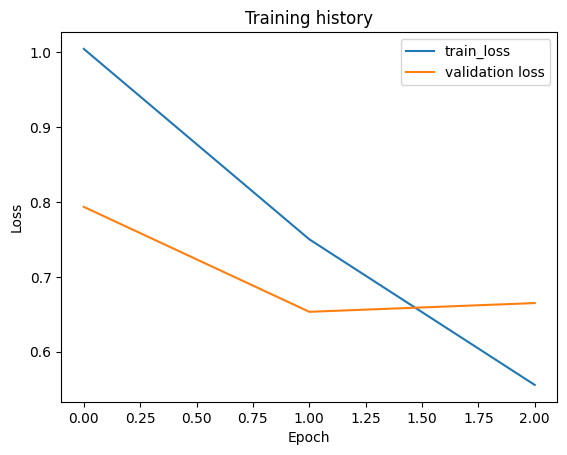

In [ ]:
plt.plot(train_loss_history, label='train_loss')
plt.plot(dev_loss_history, label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

## **Calculating evaluation metrics**

In [ ]:
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support

model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc:storage)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, state_dict=model_state_dict, num_labels = num_label)
model.to(device)

model.eval()

#_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)

#print("Training performance : ", precision_recall_fscore_support(train_correct, train_predicted, average='micro'))
print("Dev performance : ", precision_recall_fscore_support(dev_correct, dev_predicted, average='macro'))

from sklearn.metrics import f1_score

print("Macro F1-score = ", f1_score(dev_correct, dev_predicted, average='macro'))

Evaluation iteration: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]

Dev performance :  (0.689464176345227, 0.6975946695465761, 0.6930031771504114, None)
Macro F1-score =  0.6930031771504114


## **Saving predictions to file**

In [ ]:
df = pd.DataFrame({'text': dev_texts, 'label': dev_predicted})
df.head()

,text,label
0,পাডা পুতার মাঝখানে পরে সাধারণ ২ মানুষের জিবন শ...,1
1,করোনার চাপে অনেক কিছু বন্ধ ও অনেক বিধি নিষেধ ক...,0
2,সঠিক তদন্ত করতে হবে। বিচারের আওতায় আনতে হবে য...,0
3,যে লোকটা মারা গেছে তার কি হবে তার দায়ভার কে ন...,0
4,নিউ মার্কেট এবং গুলিস্থান মার্কেটের ব্যবসায়ীর...,2


In [ ]:
df.to_csv('Saved_dir/bert-base-multilingual-cased_w_aug/multilingual_bert_t1.csv', index=False)